In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
df_sales_train = pd.read_csv("E:\kaggle\competions\Predict Future Sales/sales_train.csv")
df_sales_test = pd.read_csv("E:\kaggle\competions\Predict Future Sales/test.csv")
df_sales_shop = pd.read_csv("E:\kaggle\competions\Predict Future Sales/shops.csv")
df_sales_item = pd.read_csv("E:\kaggle\competions\Predict Future Sales/items.csv")
df_sales_item_cat = pd.read_csv("E:\kaggle\competions\Predict Future Sales/item_categories.csv")
sample_sub = pd.read_csv("E:\kaggle\competions\Predict Future Sales/sample_submission.csv")

In [3]:
df_sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [4]:
df_sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
df_sales_shop.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
df_sales_item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
df_sales_item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
df_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
df_sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
df_sales_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [11]:
df_sales_shop.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [12]:
df_sales_item.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [13]:
df_sales_item_cat.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [14]:
df_sales_train.shape

(2935849, 6)

In [15]:
df_sales_test.shape

(214200, 3)

In [16]:
df_sales_train['date'] = pd.to_datetime(df_sales_train['date'], format = '%d.%m.%Y')
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [17]:
df_sales_train['shop_id'].unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

## outlier

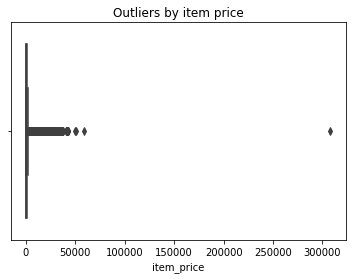

In [18]:
sns.boxplot(x = df_sales_train.item_price)
plt.title('Outliers by item price');

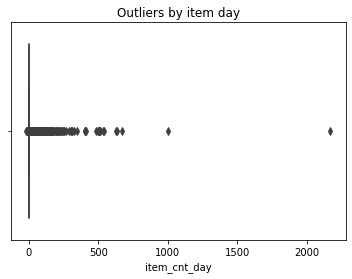

In [19]:
sns.boxplot(x = df_sales_train.item_cnt_day)
plt.title('Outliers by item day');

In [20]:
df_sales_train = df_sales_train[df_sales_train.item_price<100000]
df_sales_train = df_sales_train[df_sales_train.item_cnt_day<1001]

There is one tuple with item price less than 0 replacing with median

In [21]:
median = df_sales_train[(df_sales_train.shop_id==32)&(df_sales_train.item_id==2973)&(df_sales_train.date_block_num==4)&(df_sales_train.item_price>0)].item_price.median()
df_sales_train.loc[df_sales_train.item_price<0, 'item_price'] = median

Several shops is duplicated which can be determine by shop name

In [22]:
# Якутск Орджоникидзе, 56
df_sales_train.loc[df_sales_train.shop_id == 0, 'shop_id'] = 57
df_sales_test.loc[df_sales_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_sales_train.loc[df_sales_train.shop_id == 1, 'shop_id'] = 58
df_sales_test.loc[df_sales_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_sales_train.loc[df_sales_train.shop_id == 10, 'shop_id'] = 11
df_sales_test.loc[df_sales_test.shop_id == 10, 'shop_id'] = 11

 grouping training by shop_id and item_id


In [23]:
df_sales_train_grouped = df_sales_train.groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()


## Data Visualization

### Bottom 10 sales by shop

In [24]:
df_sales_train_grouped_negative = df_sales_train_grouped.groupby('shop_id').sum().reset_index().sort_values(by='item_cnt_day').head(10)

In [25]:
df_sales_shop_labels = df_sales_shop.loc[df_sales_shop['shop_id'].isin(df_sales_train_grouped_negative['shop_id']),'shop_name'].reset_index()
legend_list  = df_sales_shop_labels.apply((lambda x : str(x['index']) + ' --> ' + x['shop_name']),axis=1)

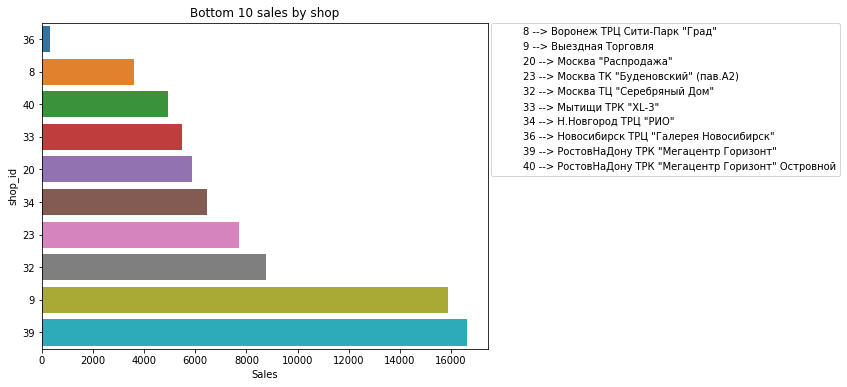

In [26]:
plt.figure(figsize=(8,6))
sns.barplot(y='shop_id',x='item_cnt_day',data=df_sales_train_grouped_negative,
            order=df_sales_train_grouped_negative['shop_id'],orient='h')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1.3, 0.515, 0.5, 0.5))
plt.xlabel('Sales')

for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Bottom 10 sales by shop');

## Top 10 Sales by Shop

In [27]:
df_sales_train_grouped_positive = df_sales_train_grouped.groupby('shop_id').sum().reset_index().sort_values(by='item_cnt_day',ascending=False).head(10)

In [28]:
df_sales_shop_labels = df_sales_shop.loc[df_sales_shop['shop_id'].isin(df_sales_train_grouped_positive['shop_id']),'shop_name'].reset_index()
legend_list  = df_sales_shop_labels.apply((lambda x : str(x['index']) + ' --> ' + x['shop_name']),axis=1)

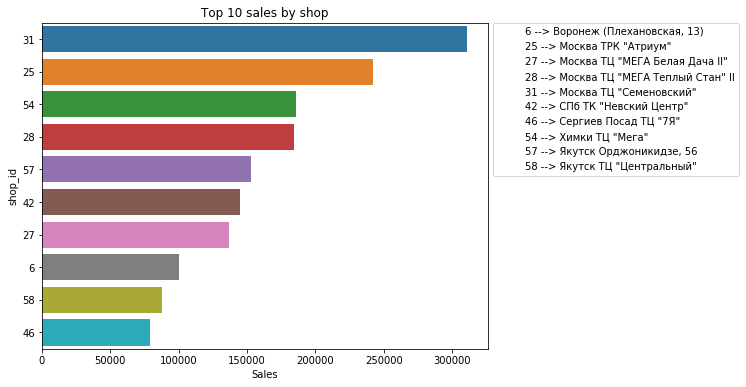

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(y='shop_id',x='item_cnt_day',data=df_sales_train_grouped_positive,
            order=df_sales_train_grouped_positive['shop_id'],orient='h')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1., 0.515, 0.5, 0.5))
plt.xlabel('Sales')

for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Top 10 sales by shop');

## Bottom 10 Sales by Item

In [30]:
df_sales_train_grouped_negative = df_sales_train_grouped.groupby('item_id').sum().reset_index().sort_values(by='item_cnt_day').head(10)

In [31]:
df_sales_item_labels = df_sales_item.loc[df_sales_item['item_id'].isin(df_sales_train_grouped_negative['item_id']),'item_name'].reset_index()
legend_list  = df_sales_item_labels.apply((lambda x : str(x['index']) + ' --> ' + x['item_name']),axis=1)

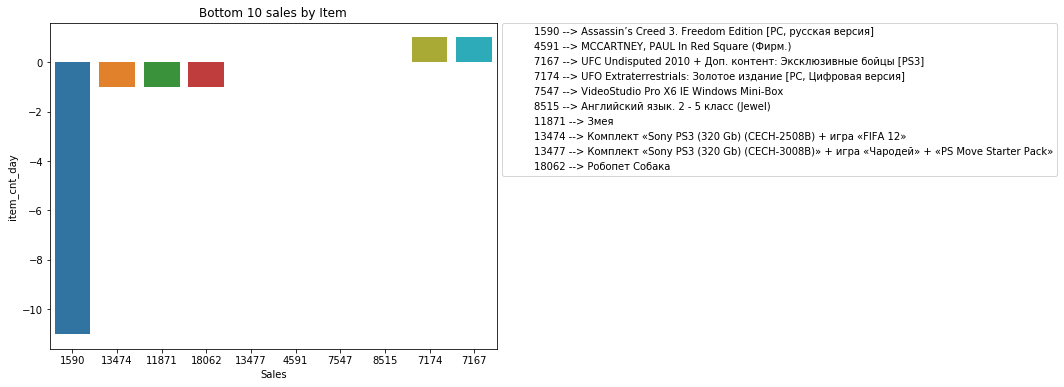

In [32]:
plt.figure(figsize=(8,6))
sns.barplot(x='item_id',y='item_cnt_day',data=df_sales_train_grouped_negative,
            order=df_sales_train_grouped_negative['item_id'],orient='v')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1.0, 0.515, 0.5, 0.5))
plt.xlabel('Sales')


for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Bottom 10 sales by Item');

## Top 10 Sales by item

In [33]:
df_sales_train_grouped_positive = df_sales_train_grouped.groupby('item_id').sum().reset_index().sort_values(by='item_cnt_day',ascending=False).head(10)

In [34]:
df_sales_item_labels = df_sales_item.loc[df_sales_item['item_id'].isin(df_sales_train_grouped_positive['item_id']),'item_name'].reset_index()
legend_list  = df_sales_item_labels.apply((lambda x : str(x['index']) + ' --> ' + x['item_name']),axis=1)

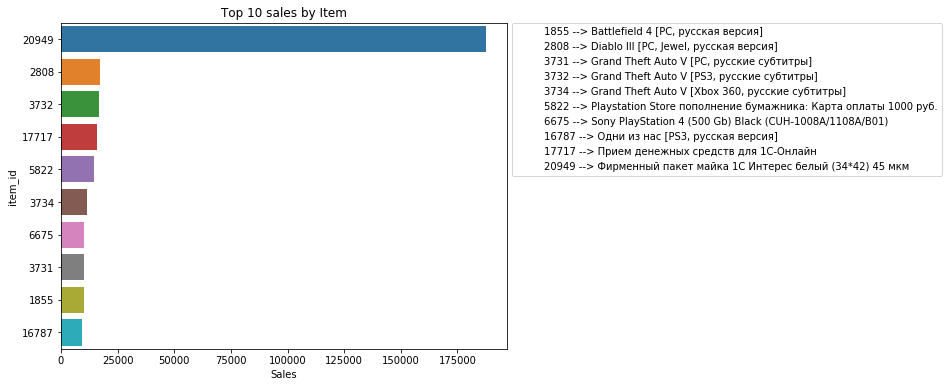

In [35]:
plt.figure(figsize=(8,6))
sns.barplot(y='item_id',x='item_cnt_day',data=df_sales_train_grouped_positive,
            order=df_sales_train_grouped_positive['item_id'],orient='h')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1.0, 0.515, 0.5, 0.5))
plt.xlabel('Sales')

for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Top 10 sales by Item');

## Bottom 10 Sales by shop and item combintion

In [36]:
df_sales_train_grouped_negative = df_sales_train_grouped.sort_values(by='item_cnt_day').head(10)

In [37]:
df_sales_train_grouped_negative['shop & item'] = df_sales_train_grouped_negative.apply((lambda x: str(x['shop_id']) + ' & '+ str(x['item_id'])),axis=1)

In [38]:
df_sales_item_labels = df_sales_item.loc[df_sales_item['item_id'].isin(df_sales_train_grouped_negative['item_id']),'item_name'].reset_index()
legend_list_item  = df_sales_item_labels.apply((lambda x : str(x['index']) + ' --> ' + x['item_name']),axis=1)
df_sales_shop_labels = df_sales_shop.loc[df_sales_shop['shop_id'].isin(df_sales_train_grouped_negative['shop_id']),'shop_name'].reset_index()
legend_list_shop  = df_sales_shop_labels.apply((lambda x : str(x['index']) + ' --> ' + x['shop_name']),axis=1)

legend_list = legend_list_item.append(legend_list_shop)

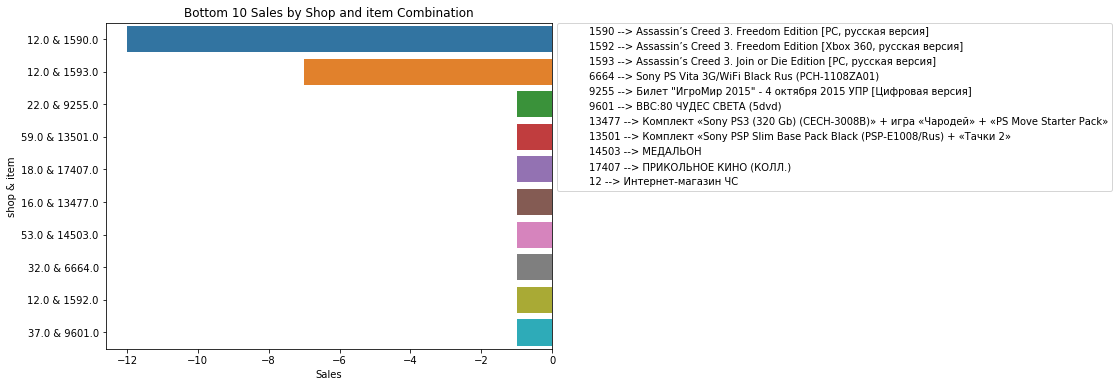

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(y='shop & item',x='item_cnt_day',data=df_sales_train_grouped_negative,
            order=df_sales_train_grouped_negative['shop & item'],orient='h')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1.0, 0.515, 0.5, 0.5))
plt.xlabel('Sales')

for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Bottom 10 Sales by Shop and item Combination');

## Top 10 Sales by Shop and item Combination

In [40]:
df_sales_train_grouped_positive = df_sales_train_grouped.sort_values(by='item_cnt_day',ascending=False).head(10)

In [41]:
df_sales_train_grouped_positive['shop & item'] = df_sales_train_grouped_positive.apply((lambda x: str(x['shop_id']) + ' & '+ str(x['item_id'])),axis=1)

In [42]:
df_sales_item_labels = df_sales_item.loc[df_sales_item['item_id'].isin(df_sales_train_grouped_positive['item_id']),'item_name'].reset_index()
legend_list_item  = df_sales_item_labels.apply((lambda x : str(x['index']) + ' --> ' + x['item_name']),axis=1)
df_sales_shop_labels = df_sales_shop.loc[df_sales_shop['shop_id'].isin(df_sales_train_grouped_positive['shop_id']),'shop_name'].reset_index()
legend_list_shop  = df_sales_shop_labels.apply((lambda x : str(x['index']) + ' --> ' + x['shop_name']),axis=1)

legend_list = legend_list_item.append(legend_list_shop)

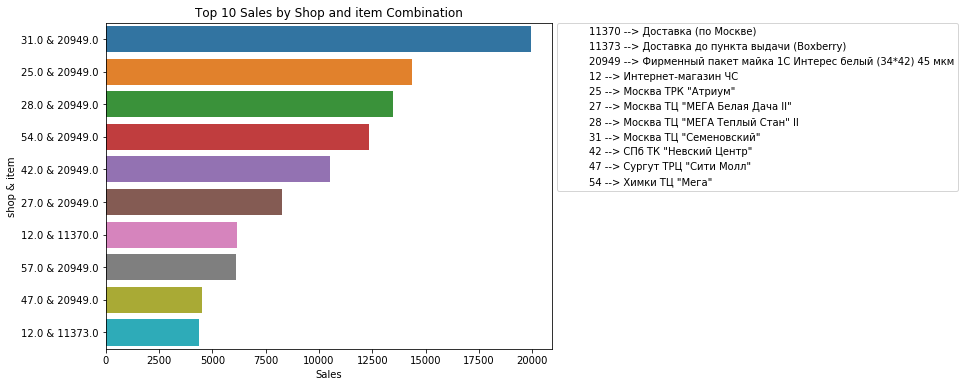

In [43]:
plt.figure(figsize=(8,6))
sns.barplot(y='shop & item',x='item_cnt_day',data=df_sales_train_grouped_positive,
            order=df_sales_train_grouped_positive['shop & item'],orient='h')
leg = plt.legend(legend_list,loc='best', bbox_to_anchor=(1.0, 0.515, 0.5, 0.5))
plt.xlabel('Sales')
for item in leg.legendHandles:
    item.set_visible(False)
plt.title('Top 10 Sales by Shop and item Combination');

## Feature Engineering

### grouping by month, shop_id, item_id

In [44]:
train = df_sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()

In [45]:
def create_lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for lag in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(lag)]
        shifted['date_block_num'] += lag
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'],how = 'left')
    
    return df


Lag Feature are being created

In [46]:
train = create_lag_feature(train,range(1,13),'item_cnt_day')
train.fillna(value=0,inplace=True)

train = create_lag_feature(train,range(1,13),'item_price')
train.fillna(value=0,inplace=True)

Grouping by month and shop_id only

In [47]:
train_shop = df_sales_train.groupby(['date_block_num','shop_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()

In [48]:
def create_lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id',col]]
    for lag in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id',col+'_shop_lag_'+str(lag)]
        shifted['date_block_num'] += lag
        df = pd.merge(df, shifted, on=['date_block_num','shop_id'],how = 'left')
    
    return df

In [49]:
train_shop = create_lag_feature(train_shop,range(1,13),'item_cnt_day')
train_shop.fillna(value=0,inplace=True)

train_shop = create_lag_feature(train_shop,range(1,13),'item_price')
train_shop.fillna(value=0,inplace=True)


train_shop.rename(columns = {'item_cnt_day':'item_cnt_day_shop','item_price':'item_price_shop'},inplace=True)

In [50]:
train_item = df_sales_train.groupby(['date_block_num','item_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()

In [51]:
def create_lag_feature(df,lags,col):
    tmp = df[['date_block_num','item_id',col]]
    for lag in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','item_id',col+'_item_lag_'+str(lag)]
        shifted['date_block_num'] += lag
        df = pd.merge(df, shifted, on=['date_block_num','item_id'],how = 'left')
    
    return df

In [52]:
train_item = create_lag_feature(train_item,range(1,13),'item_cnt_day')
train_item.fillna(value=0,inplace=True)

train_item = create_lag_feature(train_item,range(1,13),'item_price')
train_item.fillna(value=0,inplace=True)

train_item.rename(columns = {'item_cnt_day':'item_cnt_day_item','item_price':'item_price_item'},inplace=True)

### Merging above created lag features

In [53]:
train = pd.merge(train,train_item,on=['date_block_num','item_id'],how = 'left')
train = pd.merge(train,train_shop,on=['date_block_num','shop_id'],how = 'left')

month

In [54]:
train['month'] = train['date_block_num'] % 12

days

In [55]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train['days'] = train['month'].map(days).astype(np.int8)

year

In [56]:
train['Year'] = (train['date_block_num'] // 12 ) + 2013


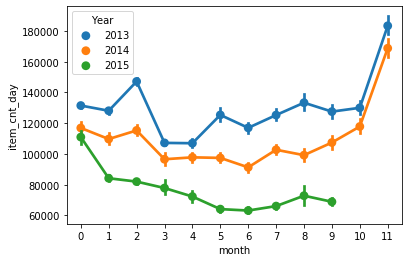

In [57]:
sns.pointplot(x='month', y='item_cnt_day', hue='Year', data=train, estimator=np.sum)

## Shop location and item Category

In [58]:
df_sales_shop['city'] = df_sales_shop['shop_name'].str.split(' ').map(lambda x: x[0])
df_sales_shop.loc[df_sales_shop.city == '!Якутск', 'city'] = 'Якутск'
df_sales_shop['city_code'] = LabelEncoder().fit_transform(df_sales_shop['city'])

coords = dict()
coords['Якутск'] = (62.028098, 129.732555, 4)
coords['Адыгея'] = (44.609764, 40.100516, 3)
coords['Балашиха'] = (55.8094500, 37.9580600, 1)
coords['Волжский'] = (53.4305800, 50.1190000, 3)
coords['Вологда'] = (59.2239000, 39.8839800, 2)
coords['Воронеж'] = (51.6720400, 39.1843000, 3)
coords['Выездная'] = (0, 0, 0)
coords['Жуковский'] = (55.5952800, 38.1202800, 1)
coords['Интернет-магазин'] = (0, 0, 0)
coords['Казань'] = (55.7887400, 49.1221400, 4)
coords['Калуга'] = (54.5293000, 36.2754200, 4)
coords['Коломна'] = (55.0794400, 38.7783300, 4)
coords['Красноярск'] = (56.0183900, 92.8671700, 4)
coords['Курск'] = (51.7373300, 36.1873500, 3)
coords['Москва'] = (55.7522200, 37.6155600, 1)
coords['Мытищи'] = (55.9116300, 37.7307600, 1)
coords['Н.Новгород'] = (56.3286700, 44.0020500, 4)
coords['Новосибирск'] = (55.0415000, 82.9346000, 4)
coords['Омск'] = (54.9924400, 73.3685900, 4)
coords['РостовНаДону'] = (47.2313500, 39.7232800, 3)
coords['СПб'] = (59.9386300, 30.3141300, 2)
coords['Самара'] = (53.2000700, 50.1500000, 4)
coords['Сергиев'] = (56.3000000, 38.1333300, 4)
coords['Сургут'] = (61.2500000, 73.4166700, 4)
coords['Томск'] = (56.4977100, 84.9743700, 4)
coords['Тюмень'] = (57.1522200, 65.5272200, 4)
coords['Уфа'] = (54.7430600, 55.9677900, 4)
coords['Химки'] = (55.8970400, 37.4296900, 1)
coords['Цифровой'] = (0, 0, 0)
coords['Чехов'] = (55.1477000, 37.4772800, 4)
coords['Ярославль'] = (57.6298700, 39.8736800, 2) 

df_sales_shop['city_coord_l'] = df_sales_shop['city'].apply(lambda x: coords[x][0])
df_sales_shop['city_coord_lt'] = df_sales_shop['city'].apply(lambda x: coords[x][1])
df_sales_shop['country_part'] = df_sales_shop['city'].apply(lambda x: coords[x][2])
df_sales_shop = df_sales_shop[['shop_id','city_code', 'city_coord_l', 'city_coord_lt', 'country_part']]


df_sales_item_cat['split'] = df_sales_item_cat['item_category_name'].str.split('-')
df_sales_item_cat['type'] = df_sales_item_cat['split'].map(lambda x: x[0].strip())
df_sales_item_cat['type_code'] = LabelEncoder().fit_transform(df_sales_item_cat['type'])
# if subtype is nan then type
df_sales_item_cat['subtype'] = df_sales_item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_sales_item_cat['subtype_code'] = LabelEncoder().fit_transform(df_sales_item_cat['subtype'])
df_sales_item_cat = df_sales_item_cat[['item_category_id','type_code', 'subtype_code']]

In [59]:
train = pd.merge(train,df_sales_item[['item_id','item_category_id']],on='item_id',how='inner')
train = pd.merge(train, df_sales_shop, on='shop_id',how = 'left')
train = pd.merge(train, df_sales_item_cat, on='item_category_id',how = 'left')

Revenues data featuring

In [60]:
def revenues(df):
    df['revenue_lag_1'] = df['item_cnt_day_lag_1']*df['item_price_lag_1']
    df['revenue_lag_item_1'] = df['item_cnt_day_item_lag_1']*df['item_price_item_lag_1']
    df['revenue_lag_shop_1'] = df['item_cnt_day_shop_lag_1']*df['item_price_shop_lag_1']
    
    return df

In [61]:
train = revenues(train)

## Split train/test 


In [62]:
train.to_pickle('train.pkl')

In [63]:
del df_sales_shop
del df_sales_item
del df_sales_item_cat
del df_sales_train
del df_sales_train_grouped
del df_sales_train_grouped_negative
del df_sales_train_grouped_positive
del legend_list
del train

In [64]:
train = pd.read_pickle('train.pkl')

In [65]:
X_train = train.drop(labels=['item_cnt_day','item_cnt_day_item','item_cnt_day_shop',
                             'item_price','item_price_item','item_price_shop'],axis=1)
y_train = train['item_cnt_day'].clip(0,20)
X_test = train[(train['date_block_num']>32)].drop(labels=['item_cnt_day','item_cnt_day_item','item_cnt_day_shop',
                             'item_price','item_price_item','item_price_shop'],axis=1)
y_test = train[(train['date_block_num']>32)]['item_cnt_day'].clip(0,20)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1609123, 88)
(1609123,)
(31531, 88)
(31531,)


## XG Boost

In [66]:
xgb = XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    max_depth=10,
    reg_alpha=0.1,
    reg_lambda=2,
    eta=0.2,
    tree_method='gpu_hist')

In [67]:
xgb.fit(X_train,y_train,eval_metric="rmse",
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
        early_stopping_rounds = 10)

XGBoostError: [00:17:06] src/learner.cc:180: XGBoost version not compiled with GPU support.

In [ ]:
predxg = xgb.predict(X_test)

In [ ]:
print(metrics.mean_squared_error(y_test,predxg))

## Feature Importance

In [ ]:
s,columns=['Coefficient'])

fig, ax = plt.subplots(1,1,figsize=(12,8))
coeff_df.sort_values(by='Coefficient',ascending=False).head(20).plot(kind='bar',ax=ax)
plt.xlabel('Features')
plt.title('Top 20 Features');

## Test Prediction

In [ ]:
df_sales_test['date_block_num'] = 34

Here I am creating one lag for test data by just replacing subsequent column name

In [ ]:
train_updated_columns = list()
for i in train.columns:
    train_updated_column = ''
    if i[-1].isnumeric():
        train_updated_column = '_'.join(i.split('_')[:-1]) +'_' + str(int(i.split('_')[-1])+1)
    elif i.find('item_cnt_day') > -1:
        train_updated_column = i + "_lag_1"
    elif i.find('item_price') > -1:
        train_updated_column = i + "_lag_1"
    else:
        train_updated_column = i
        
    
        
    if i[-1].isnumeric():
        if int(i.split('_')[-1]) < 12:
            train_updated_columns.append(train_updated_column)
    else:
        train_updated_columns.append(train_updated_column)
        

In [ ]:
train['date_block_num'] +=1
train = train[train['date_block_num']==34]
train.drop(labels=['item_cnt_day_lag_12','item_price_lag_12','item_cnt_day_item_lag_12','item_price_item_lag_12',
                  'item_cnt_day_shop_lag_12','item_price_shop_lag_12'],axis=1,inplace=True)

train.columns = train_updated_columns

In [ ]:
test = pd.DataFrame()

In [ ]:
prev = 0
for i in range(0,df_sales_test.shape[0],10000):
    test = pd.concat([test,pd.merge(df_sales_test[prev:i], train, on=['date_block_num','shop_id','item_id'],how = 'left')],ignore_index=True)
    prev=i
test = pd.concat([test,pd.merge(df_sales_test[prev:], train, on=['date_block_num','shop_id','item_id'],how = 'left')],ignore_index=True)

In [ ]:
Id = test['ID']
test['month'] = test['date_block_num'] % 12
test['days'] = test['month'].map(days).astype(np.int8)
test['Year'] = (test['date_block_num'] // 12 ) + 2013
test.fillna(value=0,inplace=True)
test.drop('ID',axis=1,inplace=True)

In [ ]:
test = revenues(test)

In [ ]:
pred_xg = xgb.predict(test[X_train.columns])

In [ ]:
pred_xg = pred_xg.reshape(pred_xg.shape[0],).clip(0,20)

In [ ]:
submission = pd.DataFrame({
        "ID": Id,
        "item_cnt_month": pred_xg
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
conda install -c nvidia -c rapidsai py-xgboost